## Name: Ziyang Zhang
## UNI: zz2732

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# sklearn
from sklearn.utils import resample

%matplotlib inline
sns.set_style("darkgrid")

# Question 1 Bootstrap

<ul>
<li>We can use Bootstrap to estimate the standard deviation of our prediction. Let $\hat{y}$ be the prediction obtained from the statistical learning model we used for the response $\bar{y}$ associated to $\bar{x}$($\bar{x}$ is fixed) , and we have $n$ total observations in the original dataset.
<li>To perform the Bootstrap resampling method, we randomly pick $n$ data points with replacement as the new Bootstrap dataset from the original dataset. <br>For this new Bootstrap dataset, we train the same statistical learning model on it and get a Bootstrap model $\hat{f}^{1}(*)$.<br> In this specific Bootstrap dataset, $\hat{f}^{1}(\bar{x})=\hat{y}^{1}$, here $\hat{y}^{1}$ is our prediction value.
<li>Repeat the procedure above for $B$ times for a large number $B$, so we can get $B$ Boostrap datasets. In total, we will have $B$ different models $\hat{f}^{i}$ and $B$ predictions $\hat{y}^{i}$ for $i=1,2,...,B$.
<li>After this Bootstrap process, we can use the formula below to estimate the standard deviation of our prediction in our original dataset: $$SE(\hat{y})=\sqrt{\frac{1}{B-1}\sum_{i=1}^{B}(\hat{y}^{i}-\frac{1}{B}\sum_{j=1}^{B}\hat{y}^{j})^2}$$

# Question 2 Bootstrap

In [161]:
default = pd.read_csv('Default.csv', index_col=0)
default.head()

,default,student,balance,income
1,No,No,729.526495,44361.62507
2,No,Yes,817.180407,12106.13470
3,No,No,1073.549164,31767.13895
4,No,No,529.250605,35704.49394
5,No,No,785.655883,38463.49588


In [162]:
# set 'Yes' to 1 and 'No' to 0 for categorical variables 'default' and 'student'
default['default'] = default['default'].replace(['Yes','No'],[1.0,0.0])
default['student'] = default['student'].replace(['Yes','No'],[1.0,0.0])
default.head()

,default,student,balance,income
1,0.0,0.0,729.526495,44361.62507
2,0.0,1.0,817.180407,12106.13470
3,0.0,0.0,1073.549164,31767.13895
4,0.0,0.0,529.250605,35704.49394
5,0.0,0.0,785.655883,38463.49588


In [163]:
default.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  float64
 1   student  10000 non-null  float64
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(4)
memory usage: 390.6 KB


## Part (a)

In [164]:
# using 'statsmodels' package to run a Logistic Regression model
formula = 'default ~ income + balance'
model = smf.logit(formula, data=default).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 29 Oct 2020   Pseudo R-squ.:                  0.4594
Time:                        18:25:42   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [165]:
pd.DataFrame({'Coefficients': model.params, 'Standard Errors': model.bse})

,Coefficients,Standard Errors
Intercept,-11.540468,0.434772
income,0.000021,0.000005
balance,0.005647,0.000227


#### Comments:
Based on the summary output above, the <b>Standard Error</b> for 'income' is 0.000005 and for 'balance' is 0.000227. Both are very close to 0.

## Part (b)

Write a function, 'boot_fn( )', that takes as input the 'Default' data set as well as an index of the observations, and that outputs the <b>Coefficient Estimates</b> for income and balance in the multiple logistic regression model.

In [166]:
def boot_fn(data):
    formula = 'default ~ income + balance'
    m = smf.logit(formula, data=data).fit(disp=0)
    return m.params[1:]
boot_fn(default)

income     0.000021
balance    0.005647
dtype: float64

The coefficient estimate for 'income' is 0.000021 and for 'balance' is 0.005647.

## Part (c)

<li>Write your own function 'boot(data, fn, R)' where 'data' is a Pandas.DataFrame, 'fn' is a function that computes a statistic, and 'R' is the number of replicates.
<li>Use this function 'boot' along with 'boot_fn' in Part (b) to estimate the <b>Standard Errors</b> of the logistic regression coefficients for 'income' and 'balance'.

In [167]:
def boot(data,fn,R):
    np.random.seed(123)
    boot_estimates=np.zeros((R,2))  # initialized 2-dimension array to store estimates later
    
    for i in range(R):
        boot_sample=resample(data)
        coefficients=fn(boot_sample)
        boot_estimates[i][0]=coefficients[0]
        boot_estimates[i][1]=coefficients[1]
    income_se=boot_estimates[:,0].std()
    balance_se=boot_estimates[:,1].std()
    boot_se=pd.DataFrame({'Bootstrap Standard Errors': [income_se, balance_se]})
    boot_se=boot_se.set_index(pd.Index(['income','balance']))
    return boot_se

In [168]:
boot_se=boot(default,boot_fn,1000)
boot_se

,Bootstrap Standard Errors
income,0.000005
balance,0.000221


The <b>Standard Error</b> obtained by drawing 1000 Bootstrap samples for 'income' is 0.000005 and for 'balance' is 0.000221.

## Part (d)

In [169]:
logit_se=pd.DataFrame({'Logit. Standard Errors': model.bse[1:]})
pd.concat([logit_se,boot_se],axis=1)

,Logit. Standard Errors,Bootstrap Standard Errors
income,0.000005,0.000005
balance,0.000227,0.000221


Comments on the estimated standard errors obtained in Part (a) and in Part (c):<br>
The <b>Standard Errors</b> for 'income' are equal to each other to the 6th decimal places, and for 'balance' are equal to each other to the 5th decimal places. Both are very close to each other. Hence, the assumptions of the Logistic Regression SE estimates are satisfied in Part (a).

# Question 3 Cross-Validation on Simulated Data

## Part (a)

In [136]:
np.random.seed(1)
x = np.random.normal(0,1,100)
y = x - 2*x**2 + np.random.normal(0,1,100)

<b>Comments:</b>
<li>In this model, we have $n=100$ and $p=2$, because we have 100 data points and 2 predictors, $X$ and $X^2$.
<li>The equation form for the model is: $$Y=X-2X^2+\epsilon,   \epsilon\sim N(0,1)$$

## Part (b)

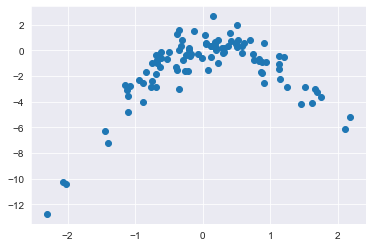

In [137]:
plt.scatter(x,y)

<b>Comments:</b>
<li>A quadratic relationship between $X$ and $Y$.
<li>Concaved down.
<li>The closer to the vertex of the parabola, the more points there are.
<li>Approximately, $X$ ranges from -2 to 2, and $Y$ ranges from -13 to 3.

## Part (c)

In [138]:
np.random.seed(23)
df=pd.DataFrame({'X':x, 'Y':y})
loo=LeaveOneOut()
scores = []
for i in range(1, 5):
    for train_index, test_index in loo.split(df):
        X_train = df['X'][train_index]
        y_train = df['Y'][train_index]
        X_test = df['X'][test_index]
        y_test = df['Y'][test_index]

        model = Pipeline([('poly', PolynomialFeatures(degree = i)),('linear', LinearRegression())])
        model.fit(X_train[:,np.newaxis], y_train)

        score = mean_squared_error(y_test, model.predict(X_test[:,np.newaxis]))
        scores.append(score)
    print('The Mean Squared Error of model %i is %f' % (i,np.mean(scores)))
    scores = []

The Mean Squared Error of model 1 is 6.260764
The Mean Squared Error of model 2 is 0.914290
The Mean Squared Error of model 3 is 0.926877
The Mean Squared Error of model 4 is 0.866912


## Part (d)

In [141]:
np.random.seed(45)
df=pd.DataFrame({'X':x, 'Y':y})
loo=LeaveOneOut()
scores = []
for i in range(1, 5):
    for train_index, test_index in loo.split(df):
        X_train = df['X'][train_index]
        y_train = df['Y'][train_index]
        X_test = df['X'][test_index]
        y_test = df['Y'][test_index]

        model = Pipeline([('poly', PolynomialFeatures(degree = i)),('linear', LinearRegression())])
        model.fit(X_train[:,np.newaxis], y_train)

        score = mean_squared_error(y_test, model.predict(X_test[:,np.newaxis]))
        scores.append(score)
    print('The Mean Squared Error of model %i is %f' % (i,np.mean(scores)))
    scores = []

The Mean Squared Error of model 1 is 6.260764
The Mean Squared Error of model 2 is 0.914290
The Mean Squared Error of model 3 is 0.926877
The Mean Squared Error of model 4 is 0.866912


<b>Comments:</b>
<li>Even if we change the random seed, the results of MSE for each model are exactly the same as in Part (c).
<li>Because Leave One Out Cross-Validation does not involve randomness. We only remove 1 data points from the whole dataset each time and train every other data points for each model. Then we calculate the average of squared errors. Essentially, every combination of 99 datapoints were used to train the model.

## Part (e)

<b>Comparison:</b>

<li>The model of 4th order polynomial model has the lowest MSE. It is a bit surprising, because I expect the 2nd order polynomial model to perform the best. However, the 2nd, 3rd, and 4th polynomial model all have very low and close MSEs compared to the 1st order model, which makes sense.
<li>Perhaps with more different random seeds for $X$ and $Y$ values, the 2nd model will perform the best for most of the times. But the actual predictions from 2nd, 3rd and 4th models should be almost identical. They are all much improved from the 1st model which only use 1 predictor $X$ without any quadratic terms.

## Part (f)

In [146]:
poly_reg_1 = PolynomialFeatures(degree = 1)
X_1 = poly_reg.fit_transform(df['X'][:,np.newaxis])
y = df['Y']
model = sm.OLS(y, X_1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Thu, 29 Oct 2020   Prob (F-statistic):            0.00209
Time:                        16:30:25   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4131      0.242     -5.849      0.0

In [147]:
poly_reg_2 = PolynomialFeatures(degree = 2)
X_2 = poly_reg_2.fit_transform(df['X'][:,np.newaxis])
y = df['Y']
model = sm.OLS(y, X_2)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     304.9
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.47e-42
Time:                        16:30:38   Log-Likelihood:                -134.42
No. Observations:                 100   AIC:                             274.8
Df Residuals:                      97   BIC:                             282.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1350      0.115      1.169      0.2

In [148]:
poly_reg_3 = PolynomialFeatures(degree = 3)
X_3 = poly_reg_3.fit_transform(df['X'][:,np.newaxis])
y = df['Y']
model = sm.OLS(y, X_3)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     204.8
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.40e-41
Time:                        16:30:43   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1280      0.115      1.111      0.2

In [149]:
poly_reg_4 = PolynomialFeatures(degree = 4)
X_4 = poly_reg_4.fit_transform(df['X'][:,np.newaxis])
y = df['Y']
model = sm.OLS(y, X_4)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     163.0
Date:                Thu, 29 Oct 2020   Prob (F-statistic):           1.24e-41
Time:                        16:30:47   Log-Likelihood:                -130.63
No. Observations:                 100   AIC:                             271.3
Df Residuals:                      95   BIC:                             284.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3140      0.136      2.311      0.0

<b>Comments:</b>
<li>By comparing the p-value of t-statistic of each coefficients in each model. 'x1' and 'x2' both always have very low p-values and much higher t-statistics compared to other variables. 
<li>Therefore, 'x2' and 'x1' are the most signifant variables when predicting 'y' values. This finding conforms with the results we got from the Cross-Validation in Part (c).
<li>That is, after adding a squared term 'x2' in the 2nd order polynomial model, we have a huge decrease in MSE compared to the model with only 'x1. However, when we added 'x3' and 'x4' after that, the MSE was about the same.

# Question 4 Ridge Regression Effect of λ

### As $\lambda$ increases from 0
## Part (a): training RSS

iii. Steadily increase.

Because as $\lambda$ increases, there will be a heavier penalty on more numbers of variables. This limit the flexibility of the model we fit, so the model will fit less and less accurate to the training dataset. Therefore training RSS will steadily increases.

## Part (b): test RSS

ii. Decrease initially, and then eventually start increasing in a U shape.

Initially, because the model is getting less complex, the increase of $\lambda$ will lead to a quicker decrease in variance than the slight increase in bias. The larger amount decrease in variance will over the increase in bias, so results in a decreasing test RSS. However, as the value of $\lambda$ keeps climbing, eventually the bias will be too large and test RSS start increasing.

## Part (c): variance

iv. Steadily decrease.

Because the increase of  𝜆 reduces the number of predictors of the model, the model is getting less and less complex. It will lead to a steady decrease in variance. 

## Part (d): (squared) bias

iii. Steadily increase.

Because the increase of 𝜆 reduces the number of predictors of the model, the model we get is less flexible and less capable to fit the training dataset. It will lead to a steady increase in (squared) bias.

## Part (e): the irreducible error

v. Remain constant.

Because the changes in $\lambda$ only affects the model coefficients, the irreducible error however is not affected by the model.

# Question 5 Comparing Lasso, Ridge, and Least Squares

In [377]:
college=pd.read_csv('College.csv')
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [378]:
# Convert the Categorical Variable 'Private':
# 'Yes' --> 1
# 'No'  --> 0
college['Private'] = college['Private'].replace(['Yes','No'],[1.0,0.0])
college = college.rename(columns={'Unnamed: 0': 'College Name'})
college.set_index(['College Name'],inplace=True)
college = college.astype(np.float64)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
College Name,,,,,,,,,,,,,,,,,,
Abilene Christian University,1.0,1660.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0
Adelphi University,1.0,2186.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,750.0,1500.0,29.0,30.0,12.2,16.0,10527.0,56.0
Adrian College,1.0,1428.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0
Agnes Scott College,1.0,417.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0
Alaska Pacific University,1.0,193.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0


In [379]:
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Private      777 non-null    float64
 1   Apps         777 non-null    float64
 2   Accept       777 non-null    float64
 3   Enroll       777 non-null    float64
 4   Top10perc    777 non-null    float64
 5   Top25perc    777 non-null    float64
 6   F.Undergrad  777 non-null    float64
 7   P.Undergrad  777 non-null    float64
 8   Outstate     777 non-null    float64
 9   Room.Board   777 non-null    float64
 10  Books        777 non-null    float64
 11  Personal     777 non-null    float64
 12  PhD          777 non-null    float64
 13  Terminal     777 non-null    float64
 14  S.F.Ratio    777 non-null    float64
 15  perc.alumni  777 non-null    float64
 16  Expend       777 non-null    float64
 17  Grad.Rate    777 non-null    float64
dtypes: 

## Part (a)

In [380]:
label=college['Apps']
features=college.loc[:, college.columns != 'Apps']
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=1)

In [381]:
features

,Private,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
College Name,,,,,,,,,,,,,,,,,
Abilene Christian University,1.0,1232.0,721.0,23.0,52.0,2885.0,537.0,7440.0,3300.0,450.0,2200.0,70.0,78.0,18.1,12.0,7041.0,60.0
Adelphi University,1.0,1924.0,512.0,16.0,29.0,2683.0,1227.0,12280.0,6450.0,750.0,1500.0,29.0,30.0,12.2,16.0,10527.0,56.0
Adrian College,1.0,1097.0,336.0,22.0,50.0,1036.0,99.0,11250.0,3750.0,400.0,1165.0,53.0,66.0,12.9,30.0,8735.0,54.0
Agnes Scott College,1.0,349.0,137.0,60.0,89.0,510.0,63.0,12960.0,5450.0,450.0,875.0,92.0,97.0,7.7,37.0,19016.0,59.0
Alaska Pacific University,1.0,146.0,55.0,16.0,44.0,249.0,869.0,7560.0,4120.0,800.0,1500.0,76.0,72.0,11.9,2.0,10922.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,0.0,1515.0,543.0,4.0,26.0,3089.0,2029.0,6797.0,3900.0,500.0,1200.0,60.0,60.0,21.0,14.0,4469.0,40.0
Xavier University,1.0,1805.0,695.0,24.0,47.0,2849.0,1107.0,11520.0,4960.0,600.0,1250.0,73.0,75.0,13.3,31.0,9189.0,83.0
Xavier University of Louisiana,1.0,1915.0,695.0,34.0,61.0,2793.0,166.0,6900.0,4200.0,617.0,781.0,67.0,75.0,14.4,20.0,8323.0,49.0


In [382]:
label

College Name
Abilene Christian University       1660.0
Adelphi University                 2186.0
Adrian College                     1428.0
Agnes Scott College                 417.0
Alaska Pacific University           193.0
                                   ...   
Worcester State College            2197.0
Xavier University                  1959.0
Xavier University of Louisiana     2097.0
Yale University                   10705.0
York College of Pennsylvania       2989.0
Name: Apps, Length: 777, dtype: float64

## Part (b)
Linear Regression

In [383]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [384]:
lr.intercept_

-487.028684086486

In [385]:
coefficients = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
coefficients

,0,0
0,Private,-380.281277
1,Accept,1.569066
2,Enroll,-0.798622
3,Top10perc,55.886845
4,Top25perc,-18.082576
5,F.Undergrad,0.064184
6,P.Undergrad,0.037252
7,Outstate,-0.091645
8,Room.Board,0.169903
9,Books,-0.123428


In [386]:
print("The test MSE of Linear Regression model is: " +str(np.mean((lr.predict(X_test) - y_test) ** 2)))

The test MSE of Linear Regression model is: 642753.8976533796


In [387]:
print("The test R^2 of Linear Regression model is: "+str(lr.score(X_test,y_test)))

The test R^2 of Linear Regression model is: 0.9460137628356747


## Part (c)
Ridge Regression

In [388]:
# First, standardize the 'features' dataset for both X_train and X_test

scaler = StandardScaler()
train_scaler = scaler.fit(X_train)
X_train_scaled = train_scaler.transform(X_train)
X_train_scaled[:,0] = X_train['Private']      # Binary Variable 'Private' should not be scaled
test_scaler = scaler.fit(X_test)
X_test_scaled = test_scaler.transform(X_test)
X_test_scaled[:,0] = X_test['Private']        # Binary Variable 'Private' should not be scaled

In [389]:
rcv_=RidgeCV(alphas=np.linspace(.1, 100, 1000), cv=10)
rcv.fit(X_train_scaled, y_train) 

RidgeCV(alphas=array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,
         7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,
         8.2,   8.3,   8.4,...
        94.6,  94.7,  94.8,  94.9,  95. ,  95.1,  95.2,  95.3,  95.4,
        95.5,  95.6,  95.7,  95.8,  95.9,  96. ,  96.1,  96.2,  96.3,
        96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,  97.2,
        97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,  98.1,
        98.2,  98.3,  98.4,  98.5,  98.6,  9

In [390]:
rcv.intercept_

3308.0879816249203

In [391]:
rcv_coefficients = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(np.transpose(rcv.coef_))], axis = 1)
rcv_coefficients

,0,0
0,Private,-298.794365
1,Accept,3428.249341
2,Enroll,-149.411414
3,Top10perc,812.798439
4,Top25perc,-216.184997
5,F.Undergrad,193.113590
6,P.Undergrad,38.733968
7,Outstate,-299.114160
8,Room.Board,204.824511
9,Books,-9.708997


In [392]:
print("The test MSE of Linear Regression model is: " + str(np.mean((rcv.predict(X_test_scaled) - y_test) ** 2)))

The test MSE of Linear Regression model is: 951690.2713951329


In [393]:
print("The test R^2 of Linear Regression model is: " + str(rcv.score(X_test_scaled,y_test)))

The test R^2 of Linear Regression model is: 0.9200655540384982


## Part (d)
Lasso Regression

In [394]:
lcv=LassoCV(alphas=np.linspace(.1, 100, 1000), cv=10)
lcv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([  0.1,   0.2,   0.3,   0.4,   0.5,   0.6,   0.7,   0.8,   0.9,
         1. ,   1.1,   1.2,   1.3,   1.4,   1.5,   1.6,   1.7,   1.8,
         1.9,   2. ,   2.1,   2.2,   2.3,   2.4,   2.5,   2.6,   2.7,
         2.8,   2.9,   3. ,   3.1,   3.2,   3.3,   3.4,   3.5,   3.6,
         3.7,   3.8,   3.9,   4. ,   4.1,   4.2,   4.3,   4.4,   4.5,
         4.6,   4.7,   4.8,   4.9,   5. ,   5.1,   5.2,   5.3,   5.4,
         5.5,   5.6,   5.7,   5.8,   5.9,   6. ,   6.1,   6.2,   6.3,
         6.4,   6.5,   6.6,   6.7,   6.8,   6.9,   7. ,   7.1,   7.2,
         7.3,   7.4,   7.5,   7.6,   7.7,   7.8,   7.9,   8. ,   8.1,
         8.2,   8.3,   8.4,...
        96.4,  96.5,  96.6,  96.7,  96.8,  96.9,  97. ,  97.1,  97.2,
        97.3,  97.4,  97.5,  97.6,  97.7,  97.8,  97.9,  98. ,  98.1,
        98.2,  98.3,  98.4,  98.5,  98.6,  98.7,  98.8,  98.9,  99. ,
        99.1,  99.2,  99.3,  99.4,  99.5,  99.6,  99.7,  99.8,  99.9,
       100. ]),
        copy_X=True, cv=10, 

In [395]:
lcv.intercept_

3266.1309545116665

In [396]:
lcv_coefficients = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(np.transpose(lcv.coef_))], axis = 1)
lcv_coefficients

,0,0
0,Private,-241.116730
1,Accept,3732.683280
2,Enroll,-223.750126
3,Top10perc,830.954900
4,Top25perc,-215.841396
5,F.Undergrad,0.000000
6,P.Undergrad,38.208357
7,Outstate,-329.179640
8,Room.Board,166.788649
9,Books,-0.000000


In [397]:
print("The test MSE of Linear Regression model is: " + str(np.mean((lcv.predict(X_test_scaled) - y_test) ** 2)))

The test MSE of Linear Regression model is: 958099.7042701633


In [398]:
print("The test R^2 of Linear Regression model is: " + str(lcv.score(X_test_scaled,y_test)))

The test R^2 of Linear Regression model is: 0.9195272124359914


## Part (g)

<b>Comments:</b>
<li>All 3 models have similar performances regarding the Test $R^2$ both around 92%.
<li>However, Linear Regression has a relatively lower Test MSE compared to RidgeCV and LassoCV. As expected, it also has a slightly higher Test $R^2$ than RidgeCV and LassoCV.
<li>RidgeCV and LassoCV have almost identical MSEs and $R^2$ values.